# TED-Talks transcripts text processing tutorial

In this notebook we will study text processing, passing through feature extraction to topic modeling in order to (1) have a first meet with text processing techniques and (2) analyze briefly some TED-Talks patterns.

In the amazing TED-Talks dataset, we have two files, one (ted_main.csv) with meta information about the talks, as # of comment, rating, related TEDs and so on; the other file has the transcripts which we'll care about in this tutorial. Even so, we'll use the ted_main.csv file to evaluate our topic modeling implementation, because it has a columns of talks' tags, useful as our "ground truth topics".

In [1]:
import numpy as np 
import pandas as pd 
from time import time

### 0.1. Transcripts loading

In [2]:
ted_main_df = pd.read_csv('data/ted_main.csv', encoding='utf-8')
transcripts_df = pd.read_csv('data/transcripts.csv', encoding='utf-8')
transcripts_df.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


### 0.2. Stopwords loading

"...stop words are words which are filtered out before or after processing of natural language data (text).[1] Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list." (Wikipedia)

In [3]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS

## 1. Text feature extraction with TFIDF


First,  consider the term-frequency (TF) matrix above, that can be extracted from a list of documents and the universe of terms in such documents.

|        | Document 1 | Document 2 | ... | Document N |
|--------|------------|------------|-----|------------|
| Term 1 | 3          | 0          | ... | 1          |
| Term 2 | 0          | 1          | ... | 2          |
| Term 3 | 2          | 2          | ... | 1          |
| ...    | ...        | ...        | ... | ...        |
| Term N | 1          | 0          | ... | 0          |


This is a huge matrix with all elements' frequency in all documents. Now consider de idf (inverse document frequency) as an operation to transform this frequency into word importance, calculated by:

$$ tfidf_{i,j} = tf_{i,j}  \times log(\frac{N}{df_{i}}) $$

Where $i$ refers to term index and $j$ document index. $N$ is the total number of documents and $df_{i}$ is the number of documents containing $i$.



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords,
                                min_df = 0.05, # cut words present in less than 5% of documents
                                max_df = 0.5)  # cut words present in more than 50% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(transcripts_df['transcript'])
print("done in %0.3fs." % (time() - t0))

## uncomment this to visualize tfidf
# print('  (j,i)         tfidf')
# print(tfidf)

done in 3.681s.


 Let's see what we can do with TFIDF... 

In our TFIFD definition, min_df and max_df were filtering words with document frequency between 5% and 50%. In another words, we're excluding very rare words (present in less than 5% of documents) and the common ones (present in more than 
50% of them).

Keeping that in mind, we'll want to see the most important words in our matrix...

In [5]:
# Let's make a function to call the top ranked words in a vectorizer
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
ranked.head()

,term,rank
1069,music,65.184451
1771,women,61.038590
1169,percent,58.935039
805,human,58.526072
193,brain,56.500979


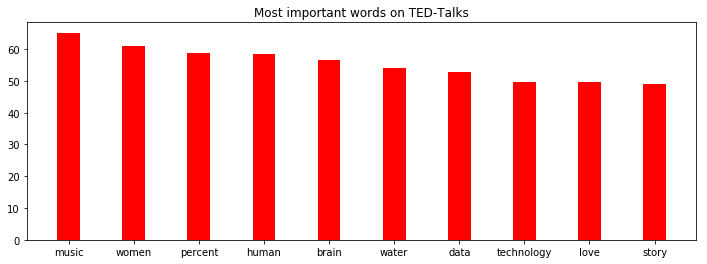

In [6]:
# Let's visualize the top10 important words in our tfidf
n_ranked = 10

y = ranked['term'].values[:n_ranked]
x = ranked['rank'].values[:n_ranked]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,4))
index = np.arange(n_ranked)
bar_width = 0.35
rects = plt.bar(index, x, bar_width, color='r')
plt.title('Most important words on TED-Talks')
plt.xticks(index , y)
plt.show()

## 2. Topic modeling (using LDA)

... In construction

In [7]:
from sklearn.decomposition import NMF

#NMF
n_topics = 10
nmf = NMF(n_topics, random_state=0)

# NMF fitting
t0 = time()
topics = nmf.fit_transform(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 1.413s.


In [8]:
# Exploring the topics
top_n_words = 5
for t_id, t in enumerate(nmf.components_):
    t_words = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    print("Topic #{}:".format(t_id),t_words)

Topic #0: ['love', 'story', 'feel', 'man', 'god']
Topic #1: ['women', 'men', 'girls', 'woman', 'sex']
Topic #2: ['music', 'play', 'sound', 'song', 'ends']
Topic #3: ['brain', 'brains', 'cells', 'human', 'body']
Topic #4: ['countries', 'percent', 'africa', 'country', 'government']
Topic #5: ['water', 'earth', 'planet', 'ocean', 'species']
Topic #6: ['cancer', 'cells', 'patients', 'disease', 'cell']
Topic #7: ['data', 'information', 'computer', 'technology', 'machine']
Topic #8: ['city', 'cities', 'design', 'building', 'buildings']
Topic #9: ['kids', 'school', 'children', 'education', 'students']


In [9]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

document_id = 4
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
threshold = 0.1
for i, p in enumerate(t[0]):
    if p>threshold:
        print('Document number {} talk about topic #{}'.format(document_id, i))
print('\nTranscript:')     
print(transcripts_df['transcript'].iloc[document_id][:500],'...')

Document number 4 talk about topic #4

Transcript:
About 10 years ago, I took on the task to teach global development to Swedish undergraduate students. That was after having spent about 20 years together with African institutions studying hunger in Africa, so I was sort of expected to know a little about the world. And I started in our medical university, Karolinska Institute, an undergraduate course called Global Health. But when you get that opportunity, you get a little nervous. I thought, these students coming to us actually have the highes ...


In [10]:
talk = ted_main_df[ted_main_df['url']==transcripts_df['url'].iloc[document_id]]
print(talk['tags'].values)
talk

[ "['Africa', 'Asia', 'Google', 'demo', 'economics', 'global development', 'global issues', 'health', 'math', 'statistics', 'visualizations']"]


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


# Conclusions

After topic modeling, we note that the topics extracted from LDA are very similar to the TED *tags* attribute. May you can ex this notebook and try it out! Change the **document_id** variable and see that happens! And don't forget to star the repo if it helps you!